# LoFTR evaluation on UAVSAR - ICEYE


In [1]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

Cloning into 'LoFTR'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 173 (delta 26), reused 142 (delta 21), pack-reused 0bjects:   4% (7/173), 4.59 MiB | 1.04 MiB/s  Receiving objects:   4% (7/173), 9.26 MiB | 1.74 MiB/sReceiving objects:   4% (8/173), 12.00 MiB | 1.98 MiB/sReceiving objects:   6% (11/173), 12.00 MiB | 1.98 MiB/sReceiving objects:  10% (18/173), 12.94 MiB | 2.03 MiB/sReceiving objects:  12% (21/173), 12.94 MiB | 2.03 MiB/sReceiving objects:  13% (23/173), 14.05 MiB | 2.05 MiB/sReceiving objects:  15% (26/173), 15.21 MiB | 2.13 MiB/sReceiving objects:  16% (28/173), 16.33 MiB | 2.09 MiB/sReceiving objects:  18% (32/173), 17.38 MiB | 2.11 MiB/sReceiving objects:  20% (35/173), 17.38 MiB | 2.11 MiB/sReceiving objects:  21% (37/173), 18.57 MiB | 2.03 MiB/sReceiving objects:  23% (40/173), 18.57 MiB | 2.03 MiB/sReceiving objects:  24% (43/173), 19.68 MiB | 2.00 MiB/sR

In [2]:
!pip install rasterio
import torch
from tqdm import tqdm
import cv2
from rasterio import warp
from rasterio.crs import CRS
from rasterio import transform as tform
import numpy as np
import matplotlib.cm as cm
from skimage.transform import AffineTransform
from skimage.measure import ransac
from matplotlib import pyplot as plt
from math import sqrt

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

In [3]:
def get_correspondence(i,j,llh_array, transform, crs):
    ''' Given row and column in SLC image, get corresponding row and column in rasterio dataset.
    @param i: row in slc.
    @param j: column in slc.
    @param llh_array: the llh as a dictionary of numpy arrays (one per lat, long, height).
    @param grd_ds: the grd as a rasterio dataset.
    @param transform: the geotransform of the rasterio dataset.
    @param crs: the crs of the rasterio dataset.
    @return i_ref: row in grd.
    @return j_ref: column in grd.
    '''
    lat = llh_array[f'llh.lat'][i][j]
    lon = llh_array[f'llh.long'][i][j]
    # Convert the EPSG:4326 coordinate to the CRS of the raster
    X, Y = warp.transform(crs, CRS.from_string("EPSG:4326"), [lon], [lat])
    # Calculate the corresponding pixel coordinate
    # i_ref, j_ref = dataset_ref.index(X, Y)
    j_ref, i_ref = ~transform * (X[0],Y[0])
    i_ref = round(i_ref)
    j_ref = round(j_ref)
    return i_ref, j_ref

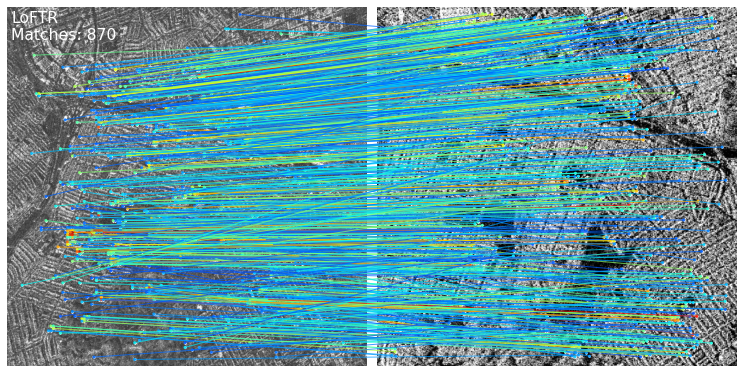

In [6]:
# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

# try with pairs 8, 7, 6, 5, 4

pair_n = 8

img0_pth = f"./data/UAVSAR/pair_{pair_n}/1.jpg"
img1_pth = f"./data/UAVSAR/pair_{pair_n}/2.jpg"
image_pair = [img0_pth, img1_pth]

img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//8*8, img0_raw.shape[0]//8*8))  # input size shuold be divisible by 8
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//8*8, img1_raw.shape[0]//8*8))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()
# Draw 
color = cm.jet(mconf, alpha=0.7)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)

# A high-res PDF will also be downloaded automatically.
make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo.pdf")


# Affine transform estimation with RANSAC

In [7]:
keypoints_left = mkpts0
keypoints_right = mkpts1
np.random.seed(0)
model, inliers = ransac(
    (keypoints_left, keypoints_right),
    AffineTransform, min_samples=4, #ProjectiveTransform
    residual_threshold=4, max_trials=10000
)
n_inliers = np.sum(inliers)

print('Number of inliers: %d.' % n_inliers)
inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
image3 = cv2.drawMatches(img0_raw, inlier_keypoints_left, img1_raw, inlier_keypoints_right, placeholder_matches, None)

# load llh
with open(f"/content/drive/MyDrive/UAVSAR - ICEYE/San Francisco/pairs/pair_{pair_n}/2_llh.npy", 'rb') as f:
    query_lat = np.load(f)
    query_long = np.load(f)
llh = {}
llh[f'llh.lat'] = query_lat
llh[f'llh.long'] = query_long

# load geotransform
with open(f"/content/drive/MyDrive/UAVSAR - ICEYE/San Francisco/pairs/pair_{pair_n}/1_tf_crs.npy", 'rb') as f:
    transform = np.load(f)
    transform = tform.Affine(*transform.flatten()[:6])
    crs = CRS.from_epsg(np.load(f))

kpidx = 24

# Visualize single match and ground truth
corr_i, corr_j = get_correspondence(int(inlier_keypoints_right[kpidx].pt[1]), 
                                    int(inlier_keypoints_right[kpidx].pt[0]), 
                                    llh, transform, crs)

print(f"SLC kp: {inlier_keypoints_right[kpidx].pt[1]}, {inlier_keypoints_right[kpidx].pt[0]}")
print(f"GRD kp: {inlier_keypoints_left[kpidx].pt[1]}, {inlier_keypoints_left[kpidx].pt[0]}")
print(f"GRD kp GT: {corr_i},  {corr_j}")

# plot single correspondence
plt.subplot(121)
plot = cv2.cvtColor(img0_raw, cv2.COLOR_GRAY2RGB)
plot = cv2.circle(plot, (corr_j, corr_i), 15, (255,0,0), 3)
plot = cv2.circle(plot, (int(inlier_keypoints_left[kpidx].pt[0]), int(inlier_keypoints_left[kpidx].pt[1])), 15, (0,0,255), 3)
plt.imshow(plot, interpolation='nearest', cmap = 'gray')
plt.title('Search', fontweight ="bold")
plt.subplot(122)
plot = cv2.cvtColor(img1_raw, cv2.COLOR_GRAY2RGB)
plot = cv2.circle(plot, (int(inlier_keypoints_right[kpidx].pt[0]), int(inlier_keypoints_right[kpidx].pt[1])), 15, (0,0,255), 3)
plt.imshow(plot, interpolation='nearest', cmap = 'gray')
plt.title('Query', fontweight ="bold")
plt.show()

plt.figure(figsize=(15, 15))
plt.imshow(image3)
plt.axis('off')
plt.show()

Number of inliers: 251.


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/UAVSAR - ICEYE/San Francisco/pairs/pair_8/2_llh.npy'

# Evaluate - Get RMSE

In [ ]:
tot_pairs = 100

# For each of the pairs
errors = []
for pair_n in tqdm(range(tot_pairs)):

  img0_pth = f"/content/drive/MyDrive/UAVSAR - ICEYE/San Francisco/pairs/pair_{pair_n}/1.jpg" # SEARCH - SATELLITE
  img1_pth = f"/content/drive/MyDrive/UAVSAR - ICEYE/San Francisco/pairs/pair_{pair_n}/2.jpg" # QUERY - UAV
  image_pair = [img0_pth, img1_pth]
  img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
  img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)

  # Input size shuold be divisible by 8
  assert(img0_raw.shape[1] % 8 == 0 and img0_raw.shape[0] % 8 == 0)
  # img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//8*8, img0_raw.shape[0]//8*8)) 
  # img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//8*8, img1_raw.shape[0]//8*8))

  img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
  img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
  batch = {'image0': img0, 'image1': img1}

  # Inference with LoFTR and get prediction
  with torch.no_grad():
      matcher(batch)
      mkpts0 = batch['mkpts0_f'].cpu().numpy()
      mkpts1 = batch['mkpts1_f'].cpu().numpy()
      mconf = batch['mconf'].cpu().numpy()

  # RANSAC
  keypoints_left = mkpts0
  keypoints_right = mkpts1
  np.random.seed(0)
  model, inliers = ransac(
      (keypoints_left, keypoints_right),
      AffineTransform, min_samples=4, #ProjectiveTransform
      residual_threshold=4, max_trials=10000
  )
  n_inliers = np.sum(inliers)

  print("\n ------------------")
  print(f'Pair {pair_n} - Number of inliers: {n_inliers}')

  # If too few inliers, discard pair!
  if n_inliers < 50 :
    print("Too few inliers -> discarding pair")
    continue

  # load llh
  with open(f"/content/drive/MyDrive/UAVSAR - ICEYE/San Francisco/pairs/pair_{pair_n}/2_llh.npy", 'rb') as f:
      query_lat = np.load(f)
      query_long = np.load(f)
  llh = {}
  llh[f'llh.lat'] = query_lat
  llh[f'llh.long'] = query_long

  # load geotransform
  with open(f"/content/drive/MyDrive/UAVSAR - ICEYE/San Francisco/pairs/pair_{pair_n}/1_tf_crs.npy", 'rb') as f:
      transform = np.load(f)
      transform = tform.Affine(*transform.flatten()[:6])
      crs = CRS.from_epsg(np.load(f))

  # For each inlier
  errors_pair = []
  indices = np.where(inliers == True)
  for idx in np.nditer(indices):

    idx = round(idx.item())

    i_slc, j_slc = round(mkpts1[idx,1]), round(mkpts1[idx,0]) # QUERY - UAV

    i_grd, j_grd = round(mkpts0[idx,1]), round(mkpts0[idx,0]) # SEARCH - SAT

    # Given point in SLC, get correspondence in GRD 
    i_ref, j_ref = get_correspondence(i_slc, j_slc, llh, transform, crs)

    # Compute RMSE contribution - append square distance
    errors_pair.append((i_grd - i_ref)**2 + (j_grd - j_ref)**2)
    errors.append((i_grd - i_ref)**2 + (j_grd - j_ref)**2)
  
  # Plot RMSE for each pair
  errors_np = np.asarray(errors_pair)
  rmse = sqrt(np.sum(errors_np)/errors_np.size)
  print("RMSE: ", rmse)

# Compute RMSE - average and root
errors_np = np.asarray(errors)
rmse = sqrt(np.sum(errors_np)/errors_np.size)
print("Final RMSE: ", rmse)